In [1]:
import os
import math
from pathlib import Path
import glob

import numpy as np
import pandas as pd
import cv2
import pydicom

from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation
matplotlib.rcParams['animation.html'] = 'jshtml'

from IPython.display import IFrame
from IPython.core.display import display, HTML
import imageio

In [2]:
import numpy as np


slice_ind = slice

def slice(input, begin, size):
    """
    Slice an array using a iterable start and length vector
    :param input: Input array to be sliced
    :param begin: Vector of indices where to start slicing
    :param size: Vector of slice lengths
    :return: Sliced array
    """

    slices = tuple(slice_ind(b, b + s) for b, s in zip(begin, size))
    return input[slices]


def batch_gather(params, indices, axis):
    """
    Gather slices from `params` according to `indices` with leading batch dims.
    This operation assumes that the leading dimensions of `indices` are dense,
    and the gathers on the axis corresponding to the last dimension of `indices`.
    More concretely it computes:
    `result[i1, ..., in, j1, ..., jm, k1, ...., kl] = params[i1, ..., in, indices[i1, ..., in, j1, ..., jm], k1, ..., kl]`
    Therefore `params` should be a Tensor of shape [A1, ..., AN, C0, B1, ..., BM],
    `indices` should be a Tensor of shape [A1, ..., AN, C1, ..., CK] and `result` will be
    a Tensor of size `[A1, ..., AN, C1, ..., CK, B1, ..., BM]`.
    Args:
      params: The array from which to gather values.
      indices: Must be one of the following types: int32, int64. Index
          array. Must be in range `[0, params.shape[axis]`, where `axis` is the
          last dimension of `indices` itself.
      axis: Must be one of the following types: int32, int64. The axis
            in `params` to gather `indices` from.
    Returns:
      An array. Has the same type as `params`.
    """

    indices_shape = indices.shape
    params_shape = params.shape
    ndim = indices.ndim
    indices_internal = indices.copy()

    # Adapt indices to act on respective batch
    accum_dim_value = 1
    for dim in range(axis, 0, -1):
        dim_value = params_shape[dim - 1]
        accum_dim_value *= params_shape[dim]
        dim_indices = np.arange(dim_value)
        dim_indices *= accum_dim_value
        dim_shape = [1] * (dim - 1) + [dim_value] + [1] * (ndim - dim)
        indices_internal += dim_indices.reshape(*dim_shape)

    flat_inner_shape_indices = np.prod(indices_shape[:(axis + 1)])
    flat_indices = indices_internal.reshape(*((flat_inner_shape_indices,) + indices_shape[(axis + 1):]))
    outer_shape = params_shape[(axis + 1):]
    flat_inner_shape_params = np.prod(params_shape[:(axis + 1)])

    flat_params = params.reshape(*((flat_inner_shape_params,) + outer_shape))
    flat_result = flat_params[flat_indices,...]
    result = flat_result.reshape(*(indices_shape + outer_shape))
    return result


def batch_histogram(values, value_range, axis, nbins=100, use_map=False):
    """
    Computes histogram with fixed width considering batch dimensions
    :param values: Array containing the values for histogram computation.
    :param value_range: Shape [2] iterable. values <= value_range[0] will be mapped to
    hist[0], values >= value_range[1] will be mapped to hist[-1].
    :param axis: Number of batch dimensions. First axis to apply histogram computation to.
    :param nbins: Scalar. Number of histogram bins.
    :param use_map: Flag indicating whether map function is used
    :return: histogram with batch dimensions.
    """

    # Get shape
    values_shape = values.shape
    batch_dim = values_shape[:axis]
    outer_dim = values_shape[axis:]
    num_batch = np.prod(batch_dim)

    if use_map:
        values_reshaped = values.reshape(*((num_batch,) + outer_dim))
        hist = np.array(list(map(lambda x: np.histogram(x, range=value_range, bins=nbins)[0], values_reshaped)))
    else:
        # Normalize
        values_double = values.astype('double')
        value_range_double = np.array(value_range).astype('double')

        # Clip values
        values_norm = (values_double - value_range_double[0]) / (value_range_double[1] - value_range_double[0])
        values_clip1 = np.maximum(values_norm, 0.5 / nbins)
        values_clip2 = np.minimum(values_clip1, 1.0 - 0.5 / nbins)

        # Shift values
        values_shift = values_clip2 + np.arange(num_batch).reshape(*(batch_dim + len(outer_dim) * (1,)))

        # Get histogram
        hist = np.histogram(values_shift, range=[0, num_batch], bins=num_batch * nbins)[0]

    return hist.reshape(*(batch_dim + (nbins,)))

In [3]:
import numpy as np
from itertools import product

def mclahe(x, kernel_size=None, n_bins=128, clip_limit=0.01, adaptive_hist_range=False):
    """
    Contrast limited adaptive histogram equalization
    :param x: numpy array to which clahe is applied
    :param kernel_size: tuple of kernel sizes, 1/8 of dimension lengths of x if None
    :param n_bins: number of bins to be used in the histogram
    :param clip_limit: relative intensity limit to be ignored in the histogram equalization
    :param adaptive_hist_range: flag, if true individual range for histogram computation of each block is used
    :return: numpy array to which clahe was applied, scaled on interval [0, 1]
    """

    if kernel_size is None:
        kernel_size = tuple(s // 8 for s in x.shape)
    kernel_size = np.array(kernel_size)

    assert len(kernel_size) == len(x.shape)

    dim = len(x.shape)

    # Normalize data
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min) / (x_max - x_min)

    # Pad data
    x_shape = np.array(x.shape)
    padding_x_length = kernel_size - 1 - ((x_shape - 1) % kernel_size)
    padding_x = np.column_stack(((padding_x_length + 1) // 2, padding_x_length // 2))
    padding_hist = np.column_stack((kernel_size // 2, (kernel_size + 1) // 2)) + padding_x
    x_hist_padded = np.pad(x, padding_hist, 'symmetric')

    x_padded = slice(x_hist_padded, kernel_size // 2, x_shape + padding_x_length)

    # Form blocks used for interpolation
    n_blocks = np.ceil(np.array(x.shape) / kernel_size).astype(np.int32)
    new_shape = np.reshape(np.column_stack((n_blocks, kernel_size)), (2 * dim,))
    perm = tuple(2 * i for i in range(dim)) + tuple(2 * i + 1 for i in range(dim))
    x_block = np.transpose(x_padded.reshape(*new_shape), perm)
    shape_x_block = np.concatenate((n_blocks, kernel_size))

    # Form block used for histogram
    n_blocks_hist = n_blocks + np.ones(dim, dtype=np.int32)
    new_shape = np.reshape(np.column_stack((n_blocks_hist, kernel_size)), (2 * dim,))
    perm = tuple(2 * i for i in range(dim)) + tuple(2 * i + 1 for i in range(dim))
    x_hist = np.transpose(x_hist_padded.reshape(*new_shape), perm)

    # Get maps
    # Get histogram
    if adaptive_hist_range:
        hist_ex_shape = np.concatenate((n_blocks_hist, [1] * dim))
        x_hist_max = np.max(x_hist, tuple(np.arange(-dim, 0)))
        x_hist_min = np.min(x_hist, tuple(np.arange(-dim, 0)))
        x_hist_norm = np.where(x_hist_min == x_hist_max, np.ones_like(x_hist_min), x_hist_max - x_hist_min)

        x_hist_scaled = (x_hist - x_hist_min.reshape(*hist_ex_shape)) / x_hist_norm.reshape(*hist_ex_shape)
    else:
        x_hist_scaled = x_hist
    hist = batch_histogram(x_hist_scaled, [0., 1.], dim, nbins=n_bins).astype(np.float32)
    # Clip histogram
    n_to_high = np.sum(np.maximum(hist - np.prod(kernel_size) * clip_limit, 0), -1, keepdims=True)
    hist_clipped = np.minimum(hist, np.prod(kernel_size) * clip_limit) + n_to_high / n_bins
    cdf = np.cumsum(hist_clipped, -1)
    cdf_min = cdf[..., :1]
    cdf_max = cdf[..., -1:]
    cdf_norm = np.where(cdf_min == cdf_max, np.ones_like(cdf_max), cdf_max - cdf_min)
    mapping = (cdf - cdf_min) / cdf_norm

    # Get global hist bins if needed
    # Compute always as they are needed for both modes
    bin_edges = np.histogram_bin_edges(x_hist_scaled, range=[0., 1.], bins=n_bins)[1:-1]
    if not adaptive_hist_range:
        # Global bins
        bin_ind = np.digitize(x_block, bin_edges)

    # Loop over maps to compute result
    res = np.zeros(shape_x_block)
    inds = [list(i) for i in product([0, 1], repeat=dim)]
    for ind_map in inds:
        # Compute bin indices if local bins are used
        if adaptive_hist_range:
            # Local bins
            hist_norm_slice_shape = np.concatenate((n_blocks, [1] * dim))
            x_hist_min_sub = slice(x_hist_min, ind_map, n_blocks)
            x_hist_norm_sub = slice(x_hist_norm, ind_map, n_blocks)
            x_block_scaled = (x_block - x_hist_min_sub.reshape(*hist_norm_slice_shape)) \
                             / x_hist_norm_sub.reshape(*hist_norm_slice_shape)
            bin_ind = np.digitize(x_block_scaled, bin_edges)
        
        # Apply map
        map_slice = slice(mapping, ind_map + [0], list(n_blocks) + [n_bins])
        mapped_sub = batch_gather(map_slice, bin_ind, dim)

        # Calculate and apply coefficients
        res_sub = mapped_sub
        for axis in range(dim):
            coeff = np.arange(kernel_size[axis], dtype=np.float32) / kernel_size[axis]
            if kernel_size[axis] % 2 == 0:
                coeff = 0.5 / kernel_size[axis] + coeff
            if ind_map[axis] == 0:
                coeff = 1. - coeff
            new_shape = [1] * (dim + axis) + [kernel_size[axis]] + [1] * (dim - 1 - axis)
            coeff = np.reshape(coeff, new_shape)
            res_sub = coeff * res_sub

        # Update results
        res = res + res_sub

    # Rescaling
    res_min, res_max = (np.min(res), np.max(res))
    res_norm = (res - res_min) / (res_max - res_min)

    # Reshape result
    new_shape = tuple((axis, axis + dim) for axis in range(dim))
    new_shape = tuple(j for i in new_shape for j in i)
    res_transposed = np.transpose(res_norm, new_shape)
    res_reshaped = res_transposed.reshape(*tuple(n_blocks[axis] * kernel_size[axis] for axis in range(dim)))

    # Recover original size
    result = slice(res_reshaped, padding_x[:, 0], x.shape)

    return result

In [4]:
def get_image_plane(data):
    x1, y1, _, x2, y2, _ = [round(j) for j in data.ImageOrientationPatient]
    cords = [x1, y1, x2, y2]

    if cords == [1, 0, 0, 0]:
        return 'Coronal'
    elif cords == [1, 0, 0, 1]:
        return 'Axial'
    elif cords == [0, 1, 0, 0]:
        return 'Sagittal'
    else:
        return 'Unknown'
    
def get_voxel(study_id, scan_type):
    imgs = []
    dcm_dir = data_root.joinpath(DATASET, study_id, scan_type)
    dcm_paths = sorted(dcm_dir.glob("*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))
    positions = []
    
    for dcm_path in dcm_paths:
        img = pydicom.dcmread(str(dcm_path))
        imgs.append(img.pixel_array)
        positions.append(img.ImagePositionPatient)
        
    plane = get_image_plane(img)
    voxel = np.stack(imgs)
    
    # reorder planes if needed and rotate voxel
    if plane == "Coronal":
        if positions[0][1] < positions[-1][1]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 0, 2))
    elif plane == "Sagittal":
        if positions[0][0] < positions[-1][0]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 2, 0))
        voxel = np.rot90(voxel, 2, axes=(1, 2))
    elif plane == "Axial":
        if positions[0][2] > positions[-1][2]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = np.rot90(voxel, 2)
    else:
        raise ValueError(f"Unknown plane {plane}")
    return voxel, plane

def normalize_contrast(voxel):
    if voxel.sum() == 0:
        return voxel
    voxel = voxel - np.min(voxel)
    voxel = voxel / np.max(voxel)
    voxel = (voxel * 255).astype(np.uint8)
    return voxel

def crop_voxel(voxel):
    if voxel.sum() == 0:
        return voxel
    keep = (voxel.mean(axis=(0, 1)) > 0)
    voxel = voxel[:, :, keep]
    keep = (voxel.mean(axis=(0, 2)) > 0)
    voxel = voxel[:, keep, :]
    keep = (voxel.mean(axis=(1, 2)) > 0)
    voxel = voxel[keep, :, :]
    return voxel

In [5]:
def filter_voxel(voxel, filter_thr):
    voxel_mean = voxel.mean(axis=(1, 2))
    keep = (voxel_mean > voxel_mean.std()*filter_thr)
    voxel = voxel[keep, :, :]
    return voxel


In [6]:
def resize_voxel(voxel, sz=(64, 256, 256)):
    output = np.zeros((sz[0], sz[1], sz[2]), dtype=np.uint8)
    if np.argmax(voxel.shape) == 0:
        for i, s in enumerate(np.linspace(0, voxel.shape[0] - 1, num=sz[0])):
            sampled = voxel[int(s), :, :]
            output[i, :, :] = cv2.resize(sampled, (sz[2], sz[1]), cv2.INTER_CUBIC)
    elif np.argmax(voxel.shape) == 1:
        for i, s in enumerate(np.linspace(0, voxel.shape[1] - 1, num=sz[1])):
            sampled = voxel[:, int(s), :]
            output[:, i, :] = cv2.resize(sampled, (sz[2], sz[0]), cv2.INTER_CUBIC)
    elif np.argmax(voxel.shape) == 2:
        for i, s in enumerate(np.linspace(0, voxel.shape[2] - 1, num=sz[2])):
            sampled = voxel[:, :, int(s)]
            output[:, :, i] = cv2.resize(sampled, (sz[1], sz[0]), cv2.INTER_CUBIC)
    return output

In [19]:
def clahe_3d(voxel):
    voxel = mclahe(voxel, kernel_size=[8,32,32],
              n_bins=128,
              clip_limit=0.01,
              adaptive_hist_range=False)
    return (voxel*255.).astype(np.uint8).clip(0, 255)


In [10]:
data_root = Path('../data')
DATASET = 'train'
study_id = '00002'
scan_type = 'T2W'

In [15]:
%%time
voxel1, plane = get_voxel(study_id, scan_type)
voxel2 = normalize_contrast(voxel1)
voxel2 = crop_voxel(voxel2)
voxel2 = filter_voxel(voxel2, filter_thr = 0.4)
voxel2 = resize_voxel(voxel2, sz=(64, 256, 256))

voxel2 = clahe_3d(voxel2)

Wall time: 3.52 s


In [7]:
for study_path in tqdm(list(data_root.joinpath(DATASET).glob("*"))):
    study_id = study_path.name
    
    print(study_id)

NameError: name 'data_root' is not defined

In [ ]:
voxel, plane = get_voxel(study_id, scan_type)

In [17]:
DATASET = 'train'
scan_types = ['FLAIR','T1w','T1wCE','T2w']
data_root = Path("../data/")

voxel_dir = '/working/voxels'
os.makedirs(voxel_dir, exist_ok=True)

filter_thr = 0.4 # voxel_mean > voxel_std_deviation*filter_thr

avgs = []

for study_path in tqdm(list(data_root.joinpath(DATASET).glob("*"))):
    study_id = study_path.name
        
    if study_id in ['00109', '00123', '00709']:
        continue

    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
        voxel = normalize_contrast(voxel)
        voxel = crop_voxel(voxel)
        voxel = filter_voxel(voxel, filter_thr)
        voxel = resize_voxel(voxel, sz=(64, 256, 256))
        
        voxel = clahe_3d(voxel)
        
        os.makedirs(f'{voxel_dir}/{scan_type}', exist_ok=True)
        
        with open(f'{voxel_dir}/{scan_type}/{study_id}.npy', 'wb') as f:
            np.save(f, voxel)


<ipython-input-18-36aa4535c661>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


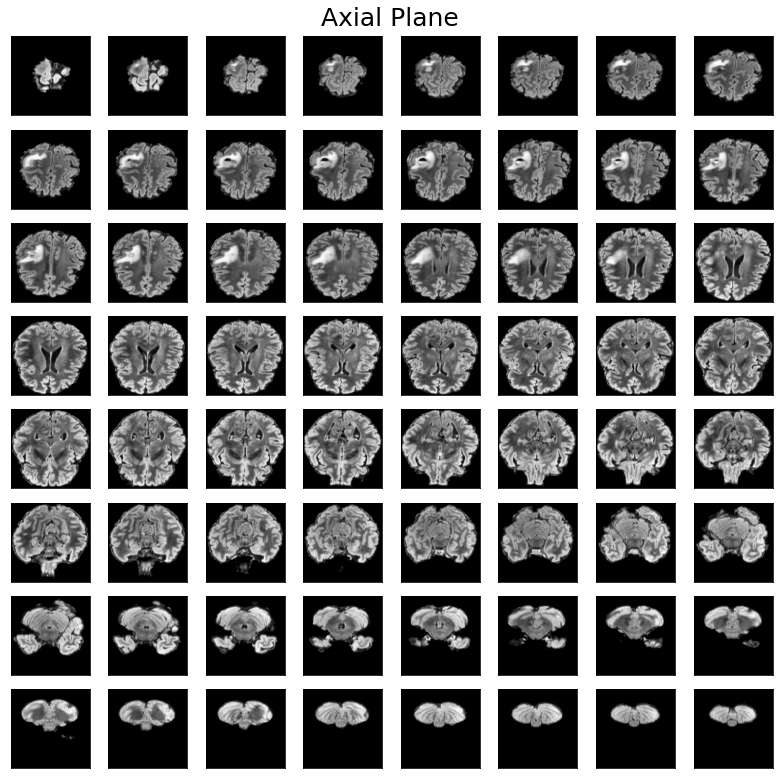

In [18]:
voxels = np.load('../voxels_processed/FLAIR/00046.npy')

sqrt = math.ceil(math.sqrt(voxels.shape[0]))
fig = plt.figure(figsize=(11, 11))
fig.suptitle('Axial Plane', x=0.5, y=0.98, size=25)

for idx in range(voxels.shape[0]):
    ax = fig.add_subplot(int(sqrt), int(sqrt), idx+1)
    ax.imshow(voxels[idx, : , :], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
fig.tight_layout()
plt.savefig(f'samples.png')
fig.show()

<ipython-input-20-136172e644c3>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


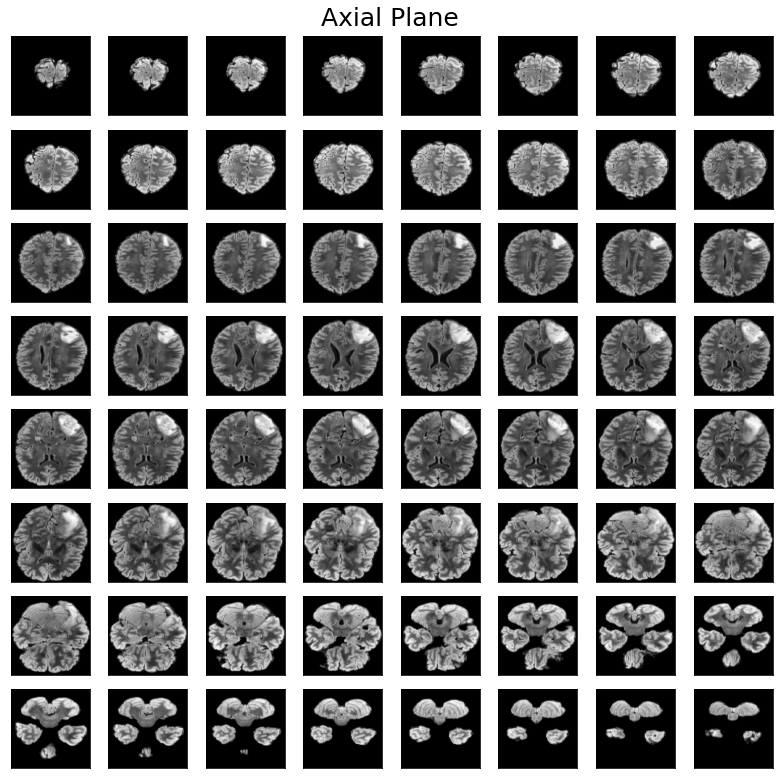

In [20]:
voxels = np.load('../voxels_processed/FLAIR/00048.npy')

sqrt = math.ceil(math.sqrt(voxels.shape[0]))
fig = plt.figure(figsize=(11, 11))
fig.suptitle('Axial Plane', x=0.5, y=0.98, size=25)

for idx in range(voxels.shape[0]):
    ax = fig.add_subplot(int(sqrt), int(sqrt), idx+1)
    ax.imshow(voxels[idx, : , :], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
fig.tight_layout()
plt.savefig(f'samples.png')
fig.show()

In [21]:
voxels.shape

(64, 256, 256)

## Save Data 

In [15]:
data_root = Path("../data/")
DATASET = 'train'
scan_types = ['FLAIR','T1w','T1wCE','T2w']

voxel_dir = Path("preprocessed_voxels/train/")
os.makedirs(voxel_dir, exist_ok=True)

In [16]:
os.path.isdir(voxel_dir.joinpath('00002'))

True

In [20]:
#create clean filtered data

avgs = []

for study_path in tqdm(list(data_root.joinpath(DATASET).glob("*"))):
    study_id = study_path.name
        
    if study_id in ['00109', '00123', '00709']:
        continue
        
    if os.path.isdir(voxel_dir.joinpath(study_id)) :
        continue

    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
        voxel = normalize_contrast(voxel)
        voxel = crop_voxel(voxel)
        voxel = filter_voxel(voxel, filter_thr = 0.4)
        voxel = resize_voxel(voxel, sz=(64, 256, 256))
        voxel = clahe_3d(voxel)
        
        os.makedirs(voxel_dir.joinpath(study_id).joinpath(scan_type), exist_ok=True)
        
        with open(voxel_dir.joinpath(study_id).joinpath(scan_type).joinpath('voxel.npy'), 'wb') as f:
            np.save(f, voxel)
            


  0%|          | 0/585 [00:00<?, ?it/s]

00667 T2w Sagittal reordered
00682 T2w Sagittal reordered
00694 T2w Sagittal reordered
00706 FLAIR Sagittal reordered
00706 T2w Sagittal reordered
00728 FLAIR Coronal reordered
00747 FLAIR Coronal reordered
00756 T1w Coronal reordered
00756 T1wCE Coronal reordered
00772 FLAIR Coronal reordered


In [21]:
DATASET = 'test'
voxel_dir = Path("preprocessed_voxels/test/")
os.makedirs(voxel_dir, exist_ok=True)

In [22]:
#create clean filtered data

avgs = []

for study_path in tqdm(list(data_root.joinpath(DATASET).glob("*"))):
    study_id = study_path.name
        
    if study_id in ['00109', '00123', '00709']:
        continue
        
    if os.path.isdir(voxel_dir.joinpath(study_id)) :
        continue

    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
        voxel = normalize_contrast(voxel)
        voxel = crop_voxel(voxel)
        voxel = filter_voxel(voxel, filter_thr = 0.4)
        voxel = resize_voxel(voxel, sz=(64, 256, 256))
        voxel = clahe_3d(voxel)
        
        os.makedirs(voxel_dir.joinpath(study_id).joinpath(scan_type), exist_ok=True)
        
        with open(voxel_dir.joinpath(study_id).joinpath(scan_type).joinpath('voxel.npy'), 'wb') as f:
            np.save(f, voxel)
            


  0%|          | 0/87 [00:00<?, ?it/s]

00091 FLAIR Coronal reordered
00114 FLAIR Axial reordered
00114 T1w Axial reordered
00114 T1wCE Axial reordered
00114 T2w Axial reordered
00125 FLAIR Axial reordered
00125 T1w Axial reordered
00125 T1wCE Axial reordered
00125 T2w Sagittal reordered
00462 FLAIR Coronal reordered
00467 T2w Coronal reordered
00535 FLAIR Coronal reordered
00647 FLAIR Coronal reordered
00647 T2w Sagittal reordered
00721 T2w Sagittal reordered


In [ ]:
print(a)

## Check  Files

In [2]:
scan_id_new = np.load('preprocessed_voxels/train/00002/FLAIR/voxel.npy')
scan_id_new.shape

(64, 256, 256)

In [3]:
scan_id_old = np.load('../voxels_processed/FLAIR/00002.npy')
scan_id_old.shape

(64, 256, 256)

In [8]:
sum(sum(sum(scan_id_old != scan_id_new)))

0

In [9]:
scan_id_new = np.load('preprocessed_voxels/train/00002/T1w/voxel.npy')
scan_id_new.shape

(64, 256, 256)

In [10]:
scan_id_old = np.load('../voxels_processed/T1w/00002.npy')
scan_id_old.shape

(64, 256, 256)

In [11]:
sum(sum(sum(scan_id_old != scan_id_new)))

0